In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pylab as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BinCNN(nn.Module):
    
    def __init__(self, nfilters):
        
        super(BinCNN, self).__init__()
        self.nf = nfilters
        self.ks = 3
        
        # 1x32x96 -> Nx32x96
        self.pad1 = nn.ReflectionPad2d(int(self.ks/2))
        self.conv1 = nn.Conv2d(1, self.nf, self.ks)
        # Nx32x96 -> 2Nx32x96
        self.pad2 = nn.ReflectionPad2d(int(self.ks/2))
        self.conv2 = nn.Conv2d(self.nf, self.nf*2, self.ks)
        # 2Nx32x96 -> 2Nx16x48
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout2d(p=0.3)
        
        self.fc1 = nn.Linear(2 * self.nf * 16 * 48, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.conv1(self.pad1(x))
        x = F.relu(x)
        x = self.conv2(self.pad2(x))
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(-1, 2 * self.nf * 16 * 48)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MriDataSet(torch.utils.data.Dataset):
    
    def __init__(self, transform=None):
        (x_train, y_train), (x_test, y_test) = np.load(
            "/home/airplaneless/source/ML/MRI-Spine/HACKATON_1/DATASET/spine_small_size.npy", 
            encoding='bytes')
        self.images = x_train
        self.labels = y_train
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, i):
        img = self.images[i]
        label = self.labels[i]
        img = img.reshape((img.shape[0], img.shape[1], 1))
        if self.transform:
            img = self.transform(img)
        return (img, int(label))

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])

In [4]:
dataset = MriDataSet(transform=transform)

In [6]:
datagenerator = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
net = BinCNN(16)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:
from tqdm import tqdm

EPOCHS = 20

epochs = tqdm(range(EPOCHS))
losses = np.zeros(EPOCHS)

net.train()

for epoch in epochs:
    for batch in datagenerator:
        imgs, labels = batch
        
        optimizer.zero_grad()
        outputs = net(imgs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses[epoch] += loss.item()        
    epochs.set_description("loss: {}".format(losses[epoch]))

loss: 0.21181260274443048: 100%|██████████| 20/20 [05:17<00:00, 18.93s/it]


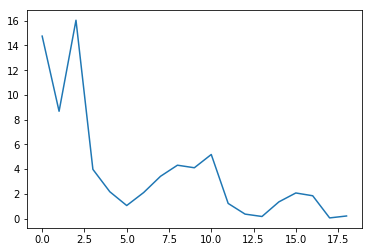

In [11]:
plt.plot(losses[1:])
plt.show()

In [12]:
def imshow(images, labels, predictions):
    for i in range(labels.shape[0]):
        img = images[i,0,:,:].numpy()
        label = labels[i].numpy()
        pred = predictions[i].detach().numpy()
        print("gt: {}".format(label))
        print("pred: {}".format(np.argmax(pred)))
        plt.imshow(img)
        plt.show()

gt: 1
pred: 1


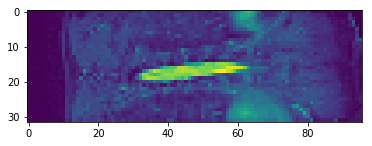

gt: 1
pred: 1


gt: 1
pred: 1


gt: 0
pred: 0


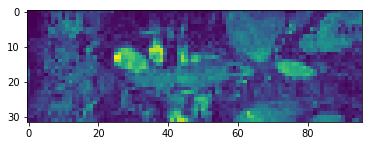

gt: 0
pred: 0


gt: 0
pred: 0


gt: 0
pred: 0


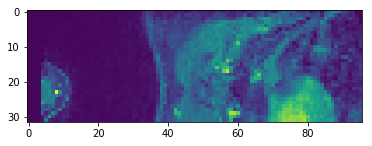

gt: 0
pred: 0


gt: 0
pred: 0


gt: 0
pred: 0


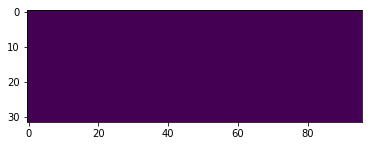

gt: 0
pred: 0


gt: 0
pred: 0


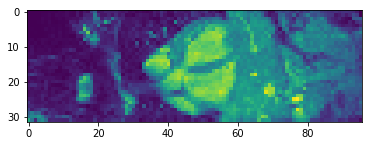

gt: 0
pred: 0


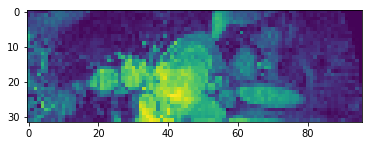

gt: 0
pred: 0


gt: 1
pred: 1


gt: 0
pred: 0


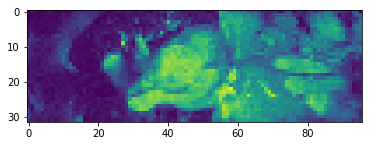

gt: 0
pred: 0


gt: 0
pred: 0


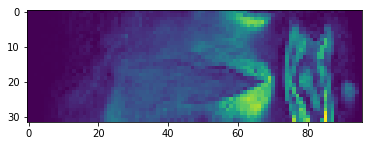

gt: 0
pred: 0


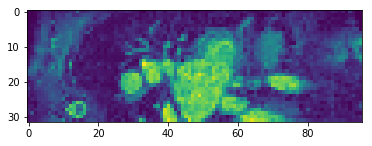

gt: 0
pred: 0


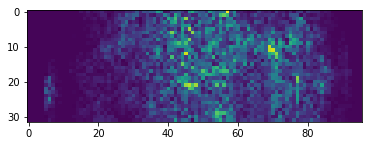

gt: 0
pred: 0


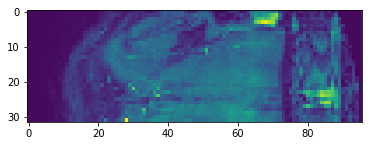

gt: 0
pred: 0


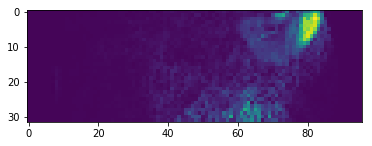

gt: 0
pred: 0


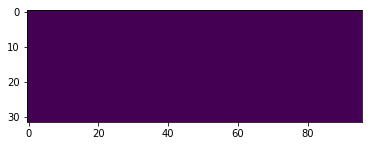

gt: 0
pred: 0


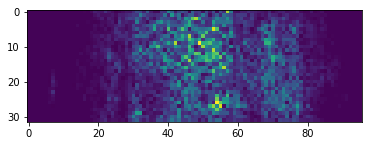

gt: 0
pred: 0


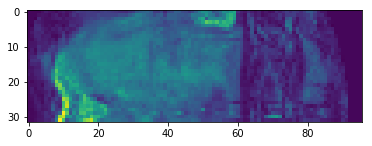

gt: 0
pred: 0


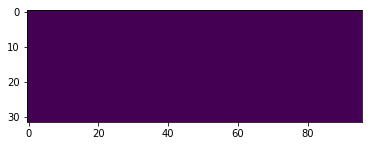

gt: 0
pred: 0


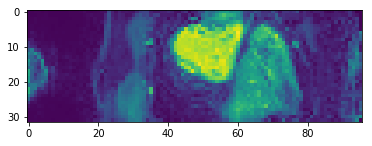

gt: 1
pred: 1


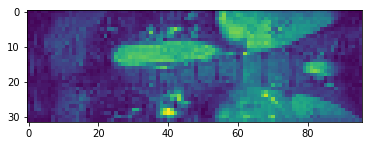

gt: 0
pred: 0


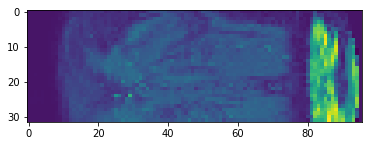

gt: 0
pred: 0


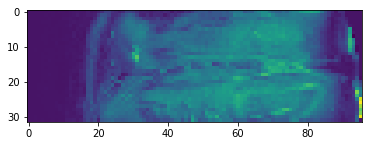

gt: 0
pred: 0


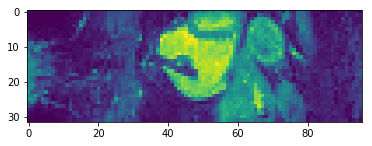

gt: 0
pred: 0


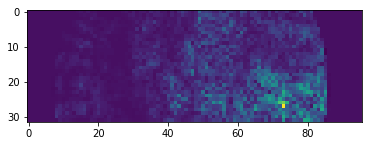

In [17]:
data = iter(datagenerator)
imgs, labels = data.next()
predictions = net(imgs.float())
imshow(imgs, labels, predictions)